In [1]:
# read j3 wrf ts files

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils_solar import Tower
from mmctools.helper_functions import calc_wind, power_spectral_density, calc_spectra
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram, plot_spectrum
import matplotlib.colors as mcolors
import re

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd

# time step of wrf runs
d02_wrf_dt = 10
d03_wrf_dt = 2
d04_wrf_dt = 0.4

# run nickname, tower name & domain, time step, spin up time in hour
sim_dict = {'meso': ['c1.d02', d02_wrf_dt, np.timedelta64(12, 'h')], 
            'les200m': ['c1.d03', d03_wrf_dt, np.timedelta64(2, 'h')], 
            'les40m': ['c1.d04', d04_wrf_dt, np.timedelta64(1, 'h')]}

# derive spectra every x duration
spectra_window = '10min'
# average all the spectra every y duration
spectra_avg_freq = '1h'
spectra_avg_time = np.timedelta64(int(re.findall('\d+', spectra_avg_freq)[0]), 
                                  re.findall('[a-z]+', spectra_avg_freq)[0])

# les_spinup = np.timedelta64(1, 'h')

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

runs_list = list(data_dir_df.index)[:-1]

# 1 obs height in m, to match wrf's heights
share_height = [4, 25, 60]

In [2]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

def read_1wrf_ts(eval_date, sim, run):
    
    col = data_dir_df[eval_date]
    sim_val = sim_dict[sim]

    # # simulation start time
    wrf_start = col['wrf_start']
    
    wrf_file_path = wrf_runs_dir+col[run]+'/z_ts/z.'+sim_val[0]
    wrf_tower = Tower(wrf_file_path)

    wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, sim_val[1])
    wrf_ds['wspd'], wrf_ds['wdir'] = calc_wind(wrf_ds)
    
    return wrf_ds

def get_obs_ds(hgt, dt): 
    
    if hgt == 4:
        nc_tail = ''
    else:
        nc_tail = '.custom'
        
    obs_nc = obs_dir+'sgpco2flxwind'+str(hgt)+'mC1.a1/sgpco2flxwind'\
        +str(hgt)+'mC1.a1.'+eval_date.replace('-', '')+'.000000'+nc_tail+'.nc'
        
    obs_ds = xr.open_mfdataset(obs_nc)

    obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

    obs_ds = obs_ds.sel(time=eval_date)
    
    # obs has higher frequency data, and wrf generates instances
    obs_ds = obs_ds.resample(time=str(dt)+'S').nearest()
    
    return obs_ds

def get_obs_spectra(obs_ds, time_start, time_end, spectra_window):
    
    obs_spectra = calc_spectra(obs_ds.sel(time=slice(time_start, time_end)),
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                           window_length=spectra_window,
                          )
    
    return obs_spectra

def get_wrf_spectra(wrf_ds, time_start, time_end, spectra_window):
    
    wrf_spectra = calc_spectra(wrf_ds.sel(datetime=slice(time_start, time_end)),
                              var_oi='wspd',
                              spectra_dim='datetime',
                              window='hamming',
                                level_dim='height',
                               window_length=spectra_window,
                              )
    
    return wrf_spectra

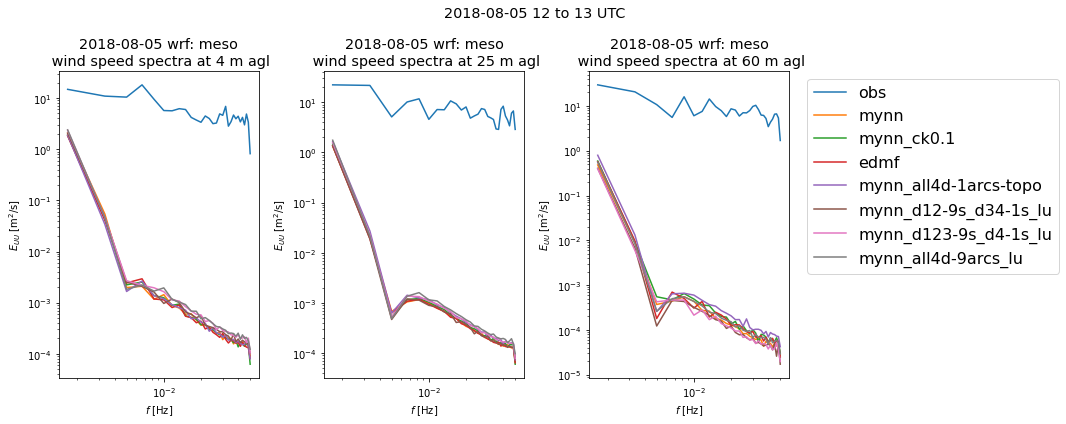

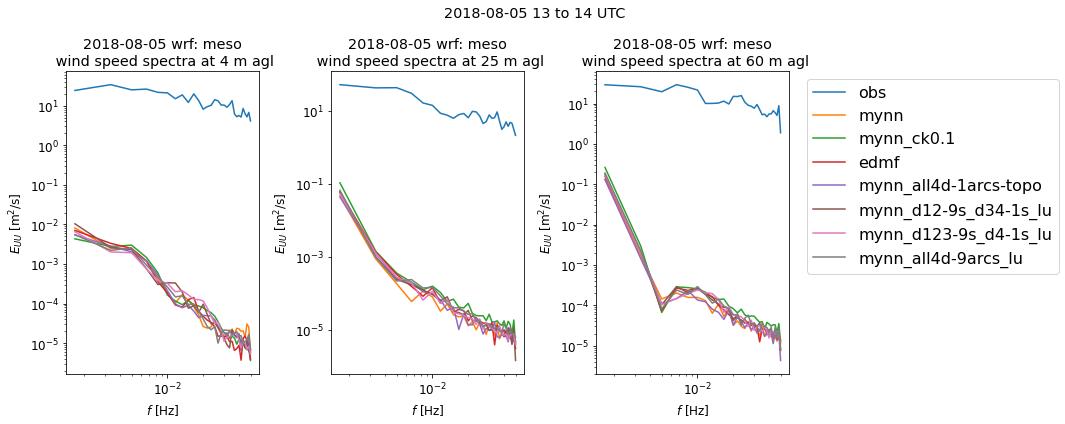

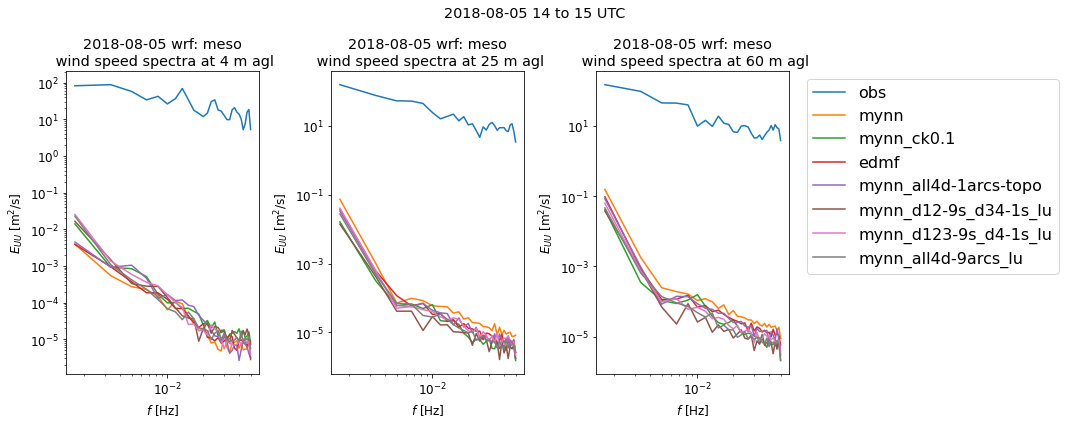

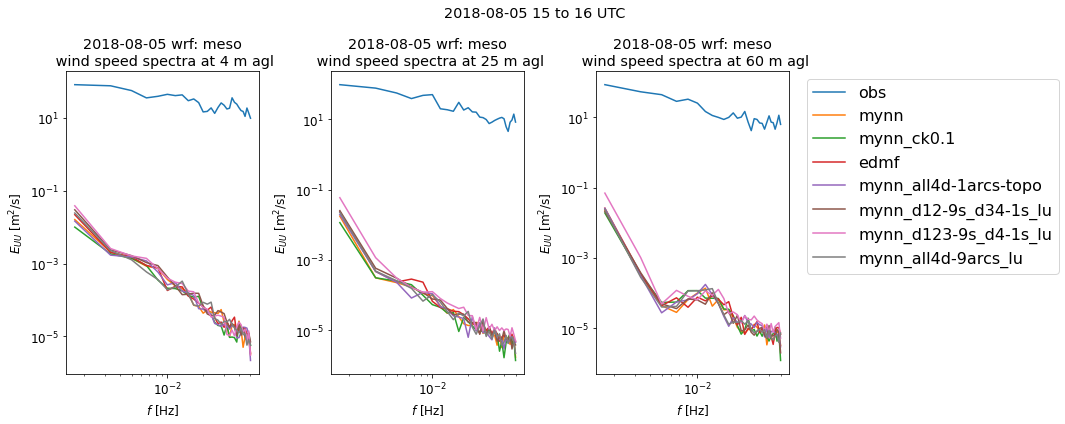

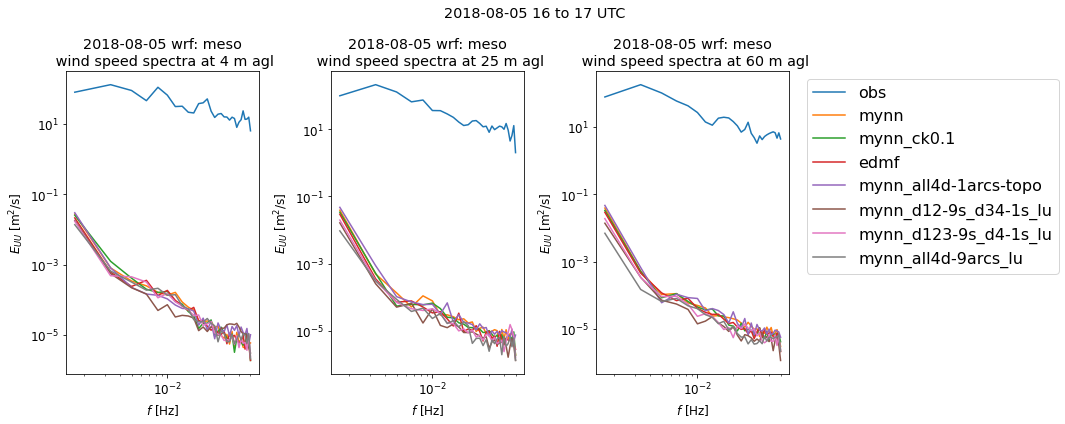

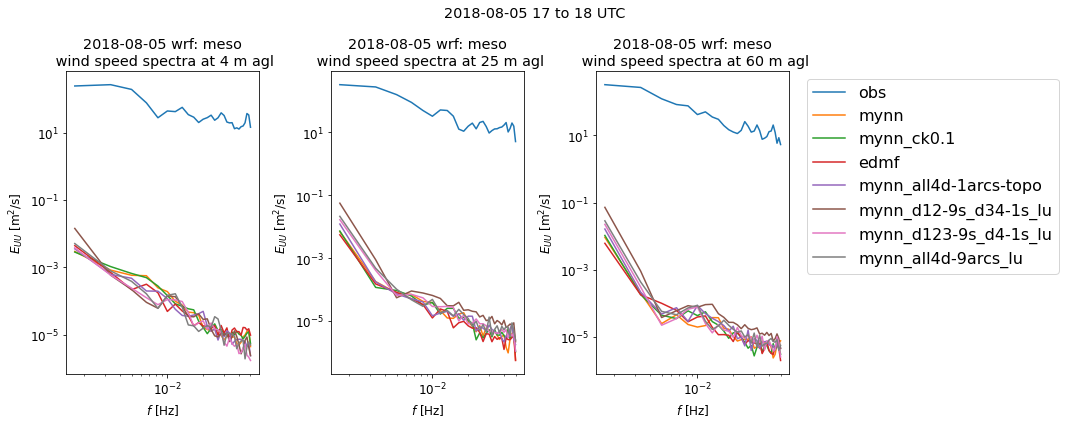

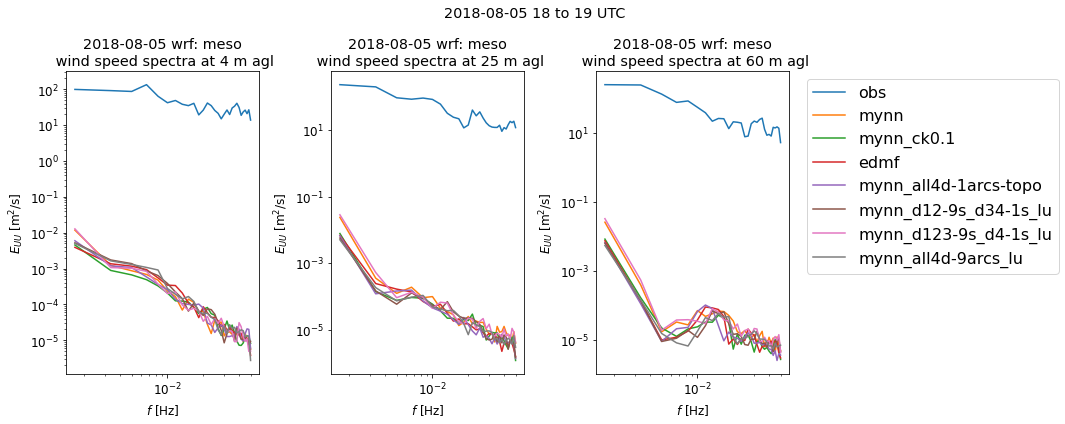

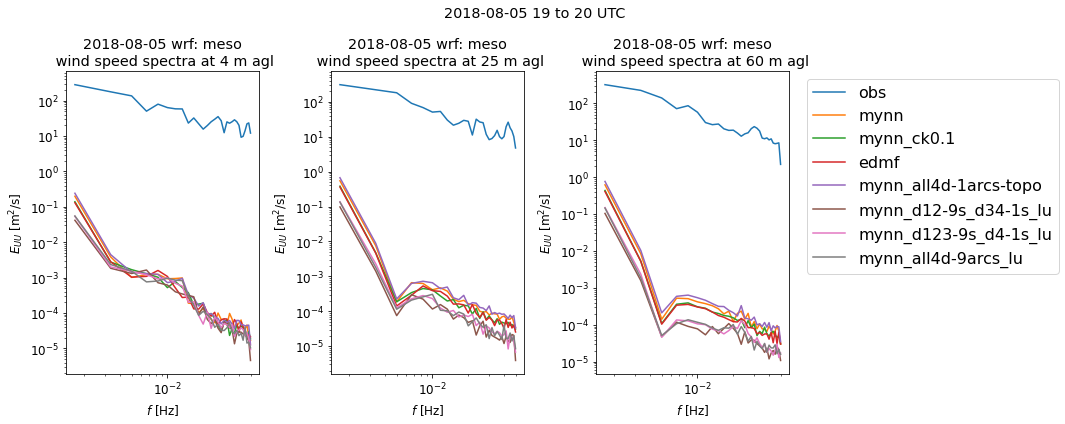

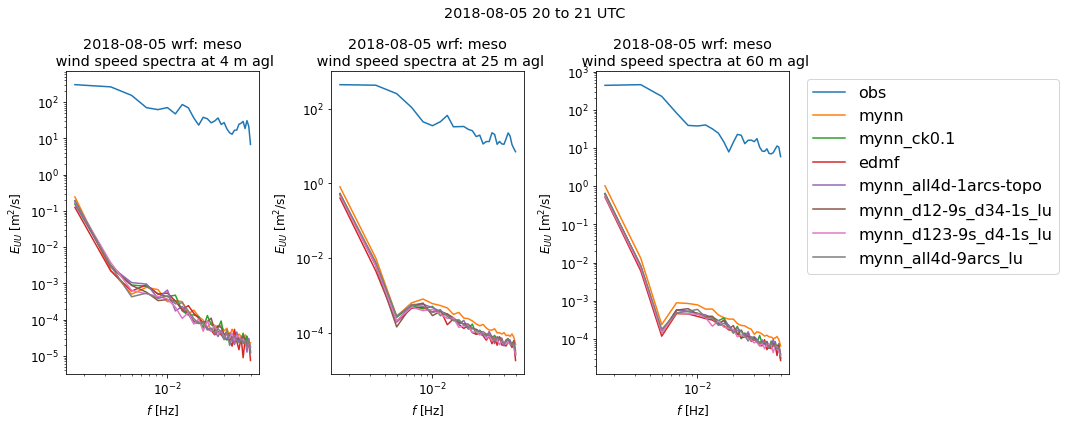

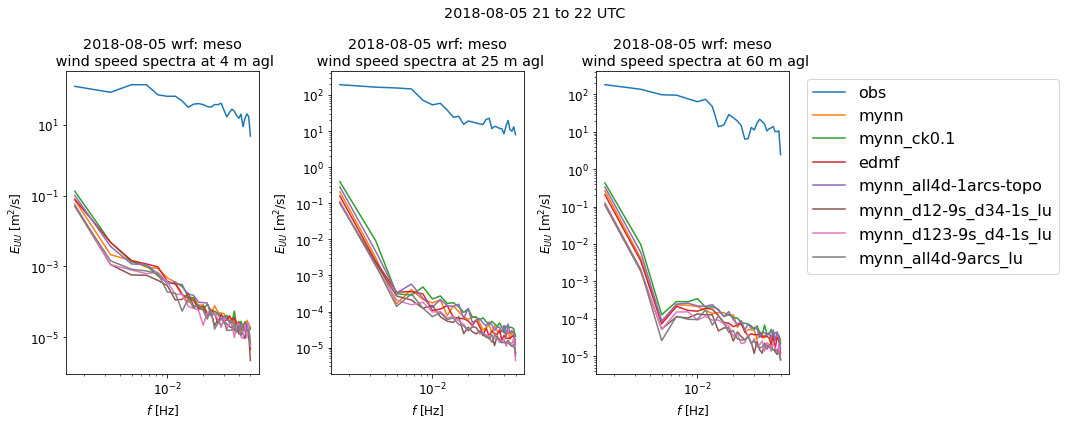

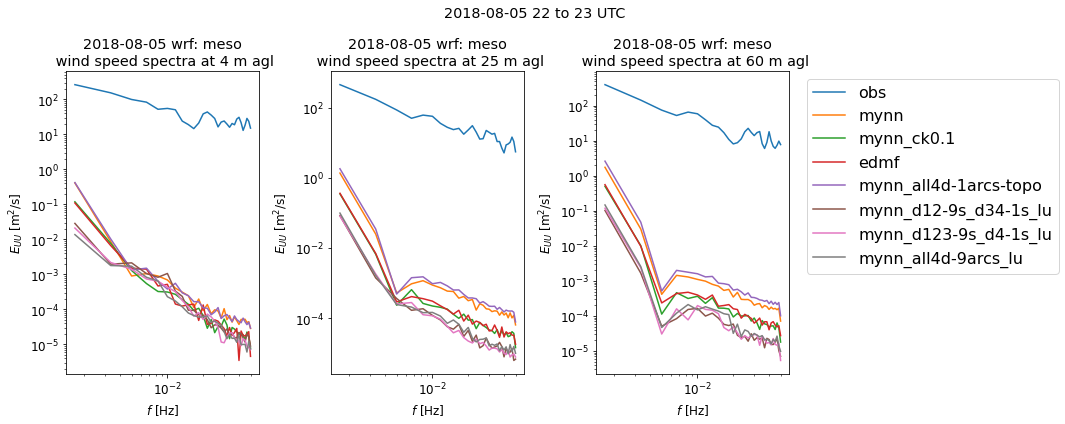

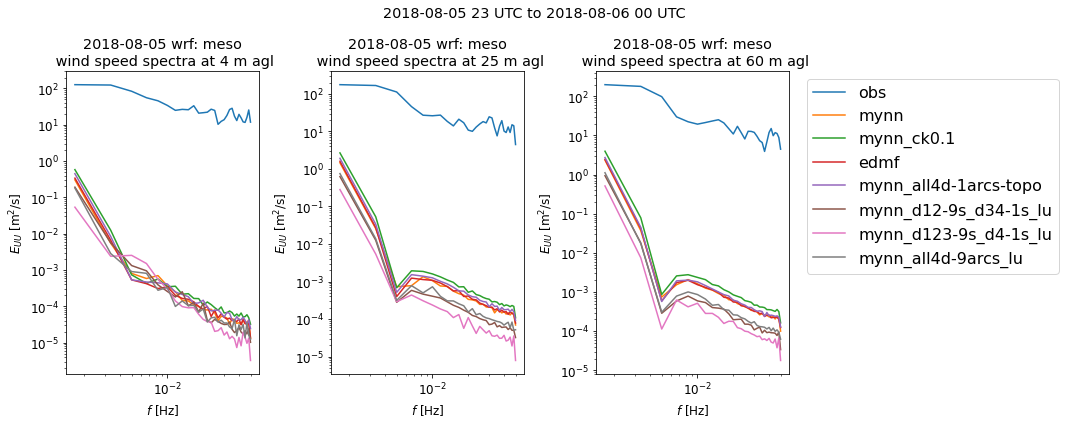

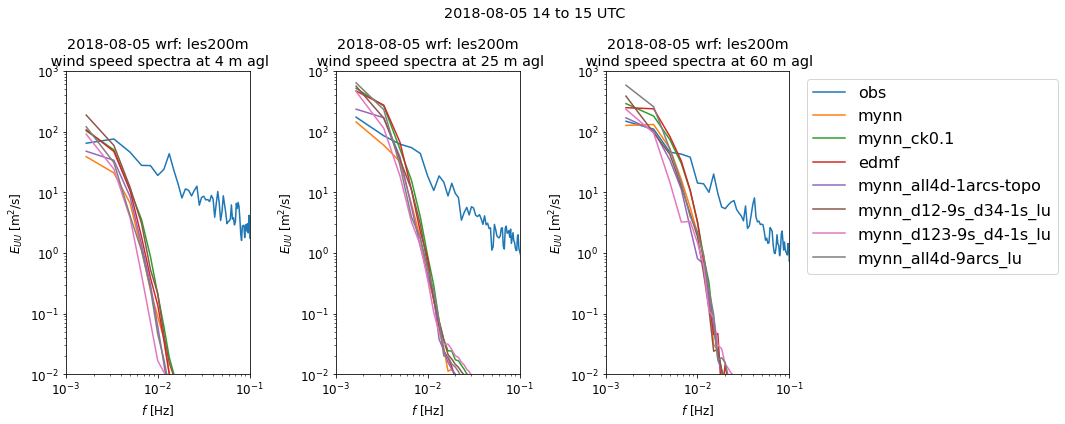

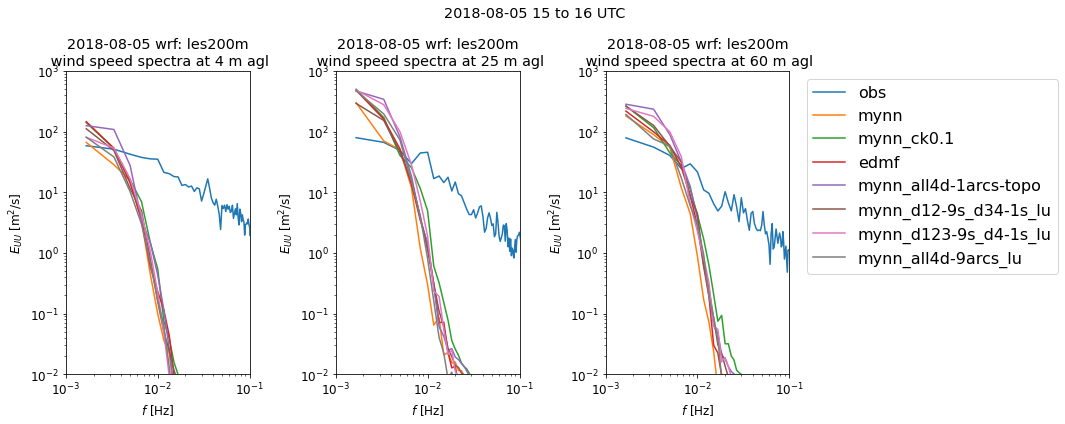

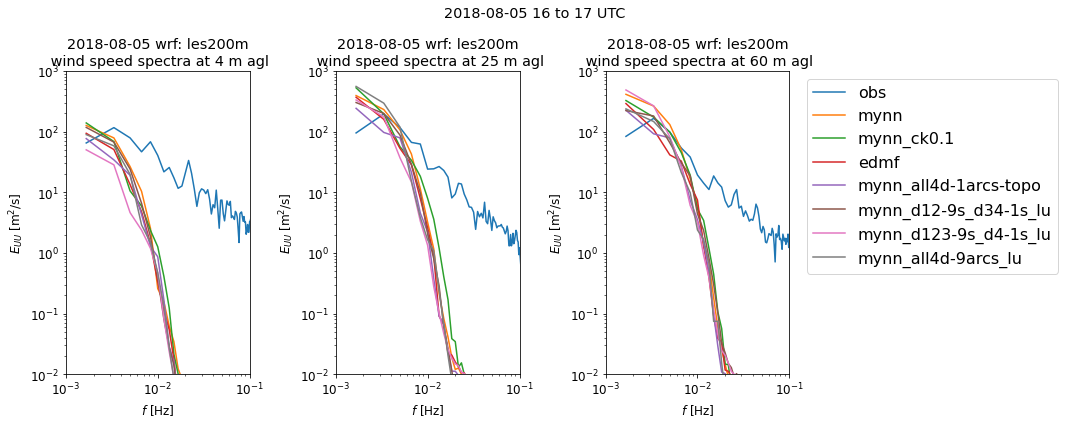

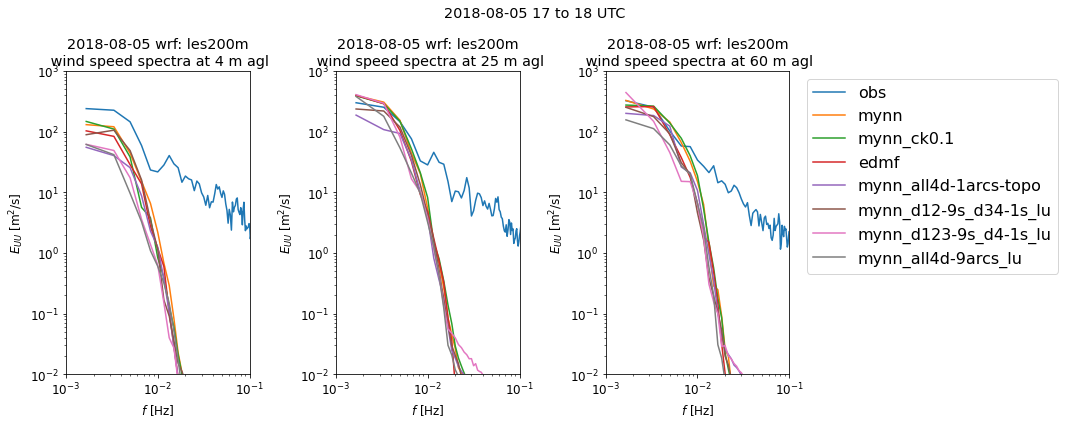

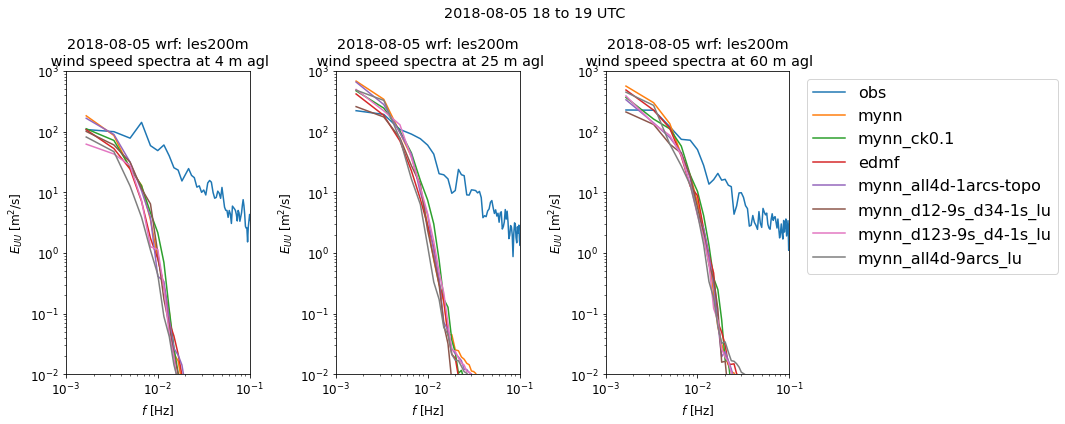

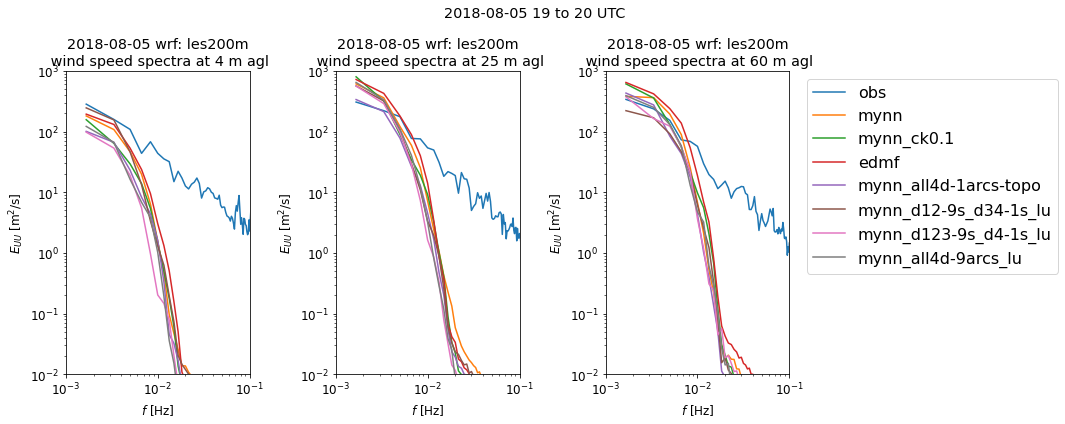

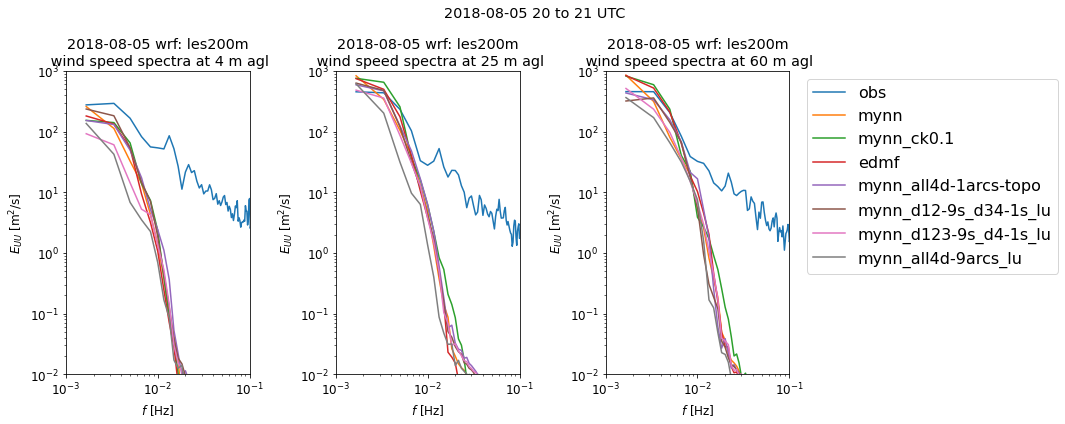

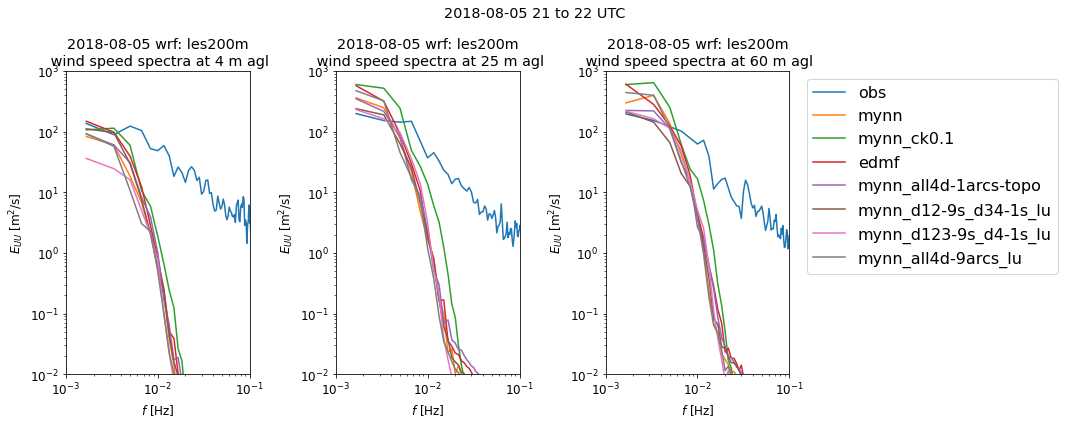

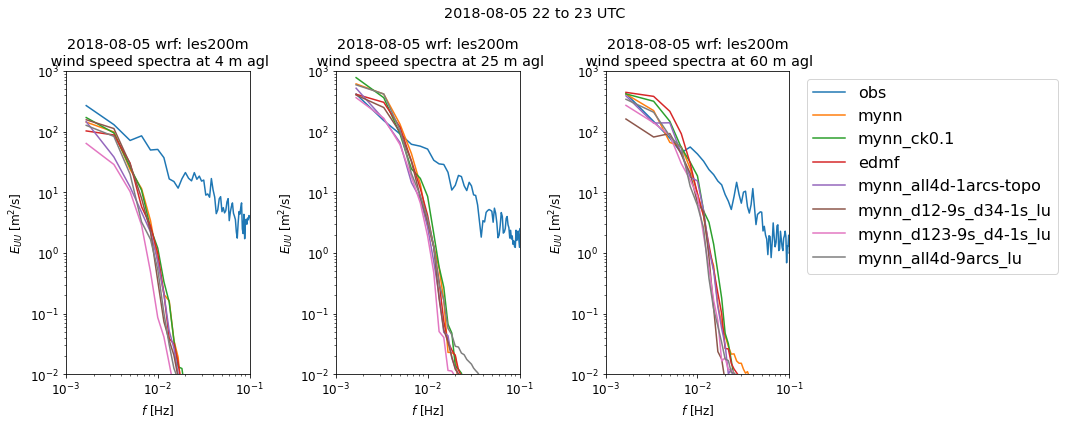

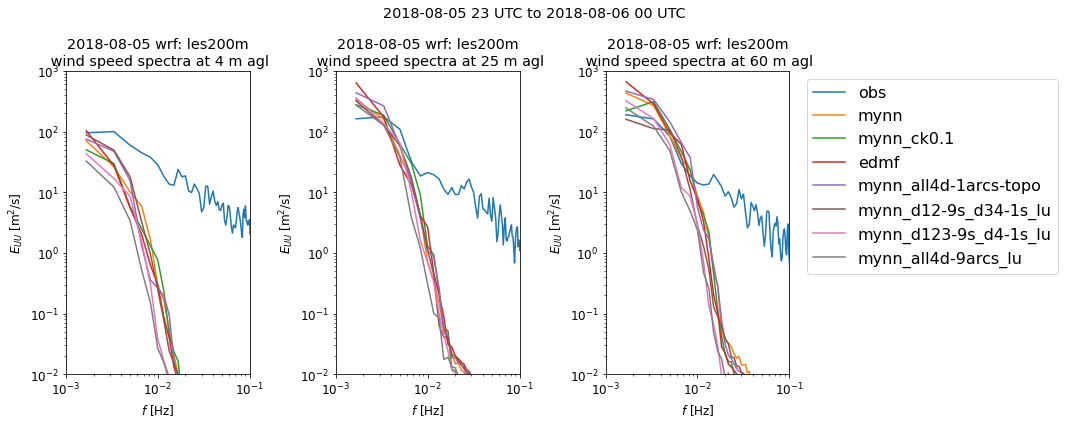

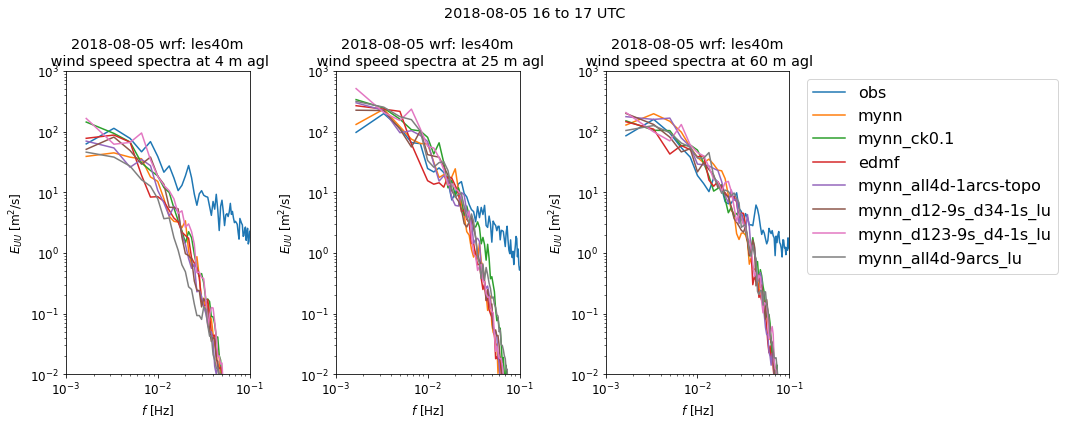

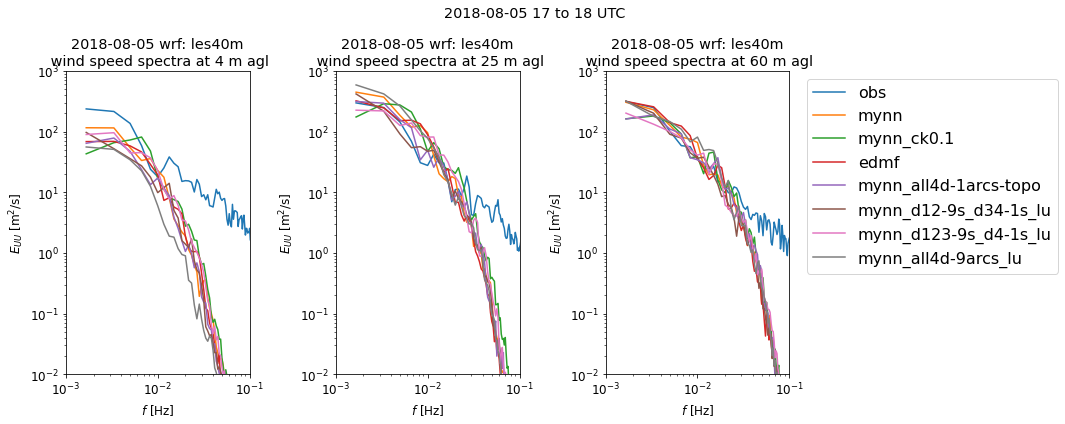

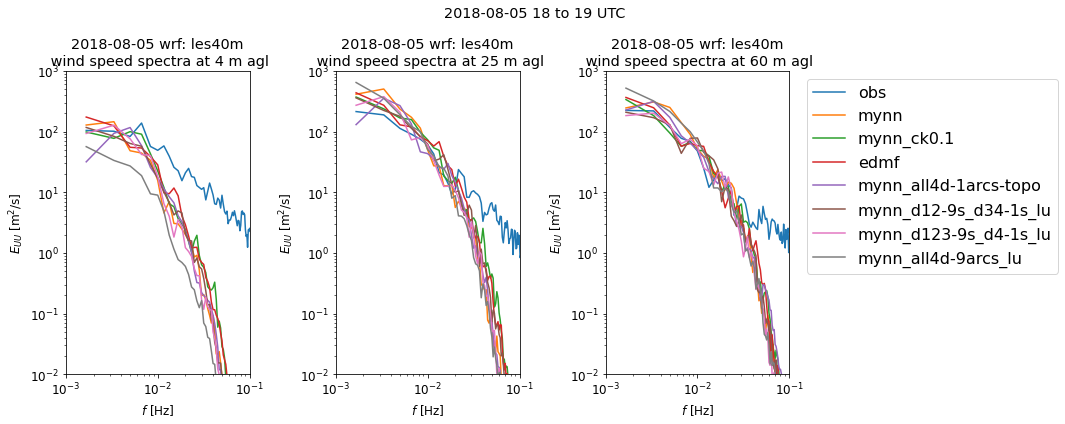

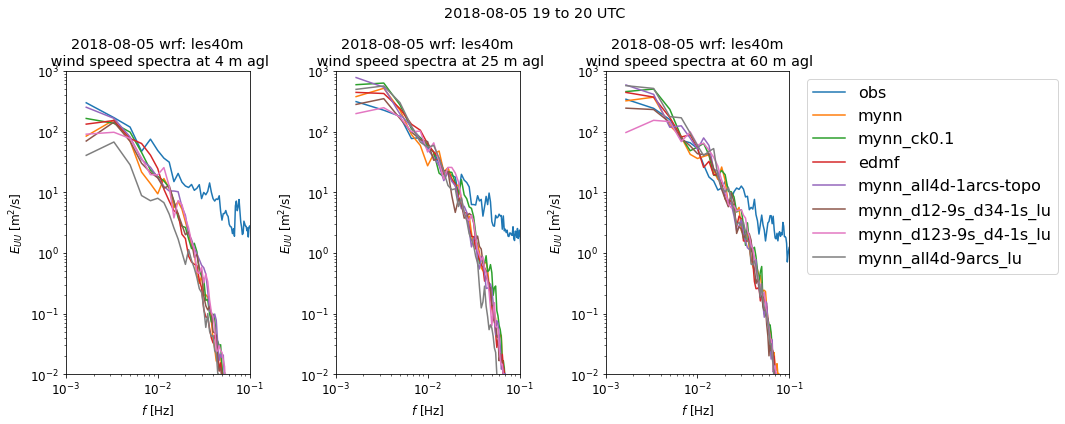

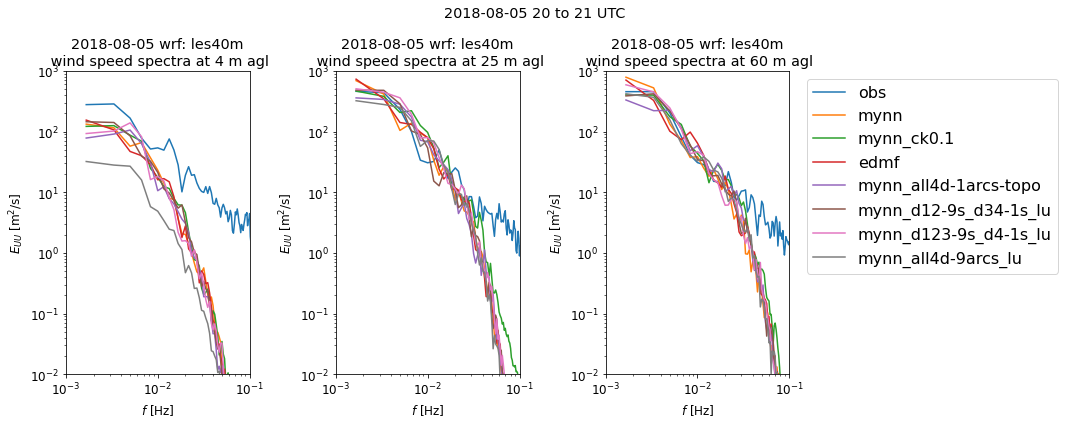

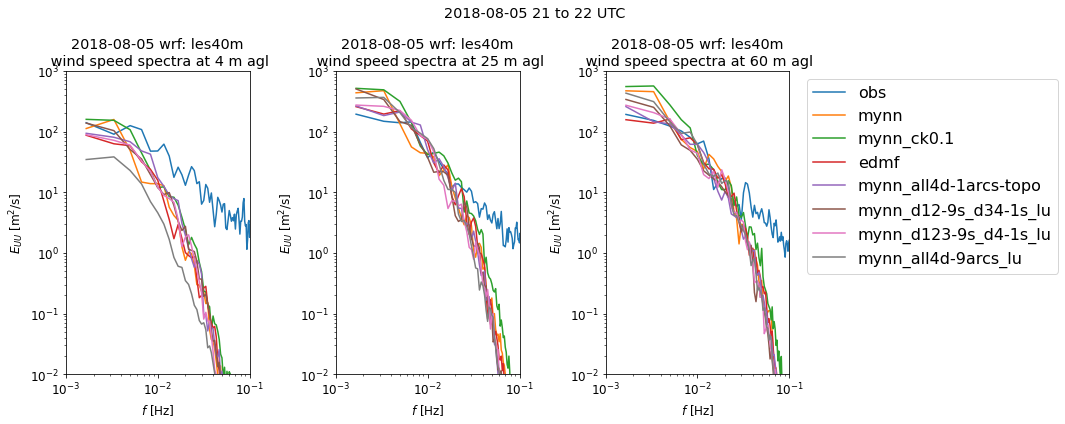

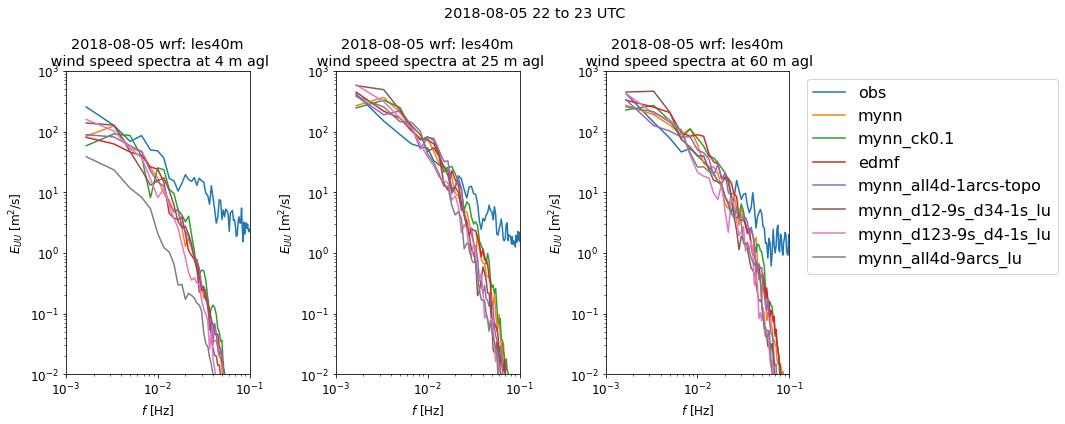

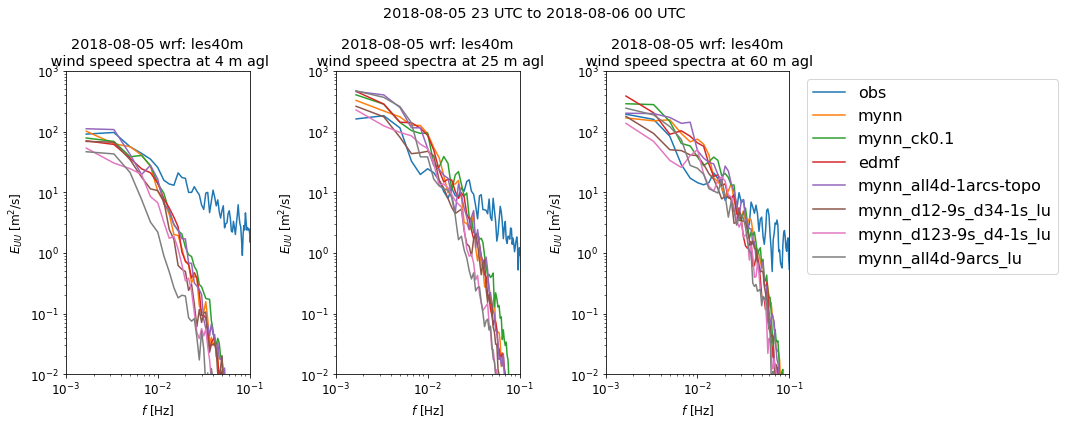

In [3]:
eval_date = '2018-08-05'
# sim = 'les200m'

for sim in sim_dict.keys(): 

    runs_dict = {}
    for run in runs_list:
        runs_dict[run] = read_1wrf_ts(eval_date, sim, run)
        
    obs4_ds = get_obs_ds(4, sim_dict[sim][1])
    obs25_ds = get_obs_ds(25, sim_dict[sim][1])
    obs60_ds = get_obs_ds(60, sim_dict[sim][1])

    for ind, val in enumerate(list(runs_dict.values())): 
        if ind == 0: 
            run_t_min = val['datetime'].min().values
            run_t_max = val['datetime'].max().values
        else: 
            if run_t_min > val['datetime'].min().values: 
                run_t_min = val['datetime'].min().values
            if run_t_max < val['datetime'].max().values:
                run_t_max = val['datetime'].max().values

    time_start = np.max([run_t_min, obs4_ds['time'].min().values]) + sim_dict[sim][2]
    time_end = np.min([run_t_max, obs4_ds['time'].max().values])

    obs4_ds = obs4_ds.sel(time=slice(time_start, time_end))
    obs25_ds = obs25_ds.sel(time=slice(time_start, time_end))
    obs60_ds = obs60_ds.sel(time=slice(time_start, time_end))

    for run in runs_list: 
        runs_dict[run] = runs_dict[run].sel(datetime=slice(time_start, time_end))

    t_list = pd.date_range(start=time_start, end=time_end, freq=spectra_avg_freq)
    
    for t in t_list: 

        obs4_spectra = get_obs_spectra(obs4_ds, t, t+spectra_avg_time, spectra_window)
        obs25_spectra = get_obs_spectra(obs25_ds, t, t+spectra_avg_time, spectra_window)
        obs60_spectra = get_obs_spectra(obs60_ds, t, t+spectra_avg_time, spectra_window)

        run_spectra_dict = {}
        for run in runs_list:
            run_spectra_dict[run] = get_wrf_spectra(runs_dict[run], t, t+spectra_avg_time, 
                                                    spectra_window)

        plot_4mspectra_dict = {'obs': obs4_spectra.to_dataframe()}
        for run in runs_list:
            plot_4mspectra_dict[run] = run_spectra_dict[run].sel(height=4).to_dataframe()

        plot_25mspectra_dict = {'obs': obs25_spectra.to_dataframe()}
        for run in runs_list:
            plot_25mspectra_dict[run] = run_spectra_dict[run].sel(height=25).to_dataframe()

        plot_60mspectra_dict = {'obs': obs60_spectra.to_dataframe()}
        for run in runs_list:
            plot_60mspectra_dict[run] = run_spectra_dict[run].sel(height=60).to_dataframe()

        fig, axs = plt.subplots(1, 3, figsize=(15, 6))

        plt.rcParams.update({'font.size': 12})

        _, ax = plot_spectrum(
                datasets=plot_4mspectra_dict,
                fields='wspd',
                showlegend=False, fig=fig, ax=axs[0])

        ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

        _, ax = plot_spectrum(
                datasets=plot_25mspectra_dict,
                fields='wspd',
                showlegend=False, fig=fig, ax=axs[1])

        ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 25 m agl')

        _, ax = plot_spectrum(
                datasets=plot_60mspectra_dict,
                fields='wspd',
                showlegend=True, fig=fig, ax=axs[2])

        ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 60 m agl')

        if t.day == (t+spectra_avg_time).day: 
            plt.suptitle(eval_date+' '+str(t.hour)+' to '+str((t+spectra_avg_time).hour)+' UTC')
        else: 
            plt.suptitle(t.strftime('%Y-%m-%d %H')+' UTC to '+(t+spectra_avg_time).strftime('%Y-%m-%d %H')+' UTC')

        if sim != 'meso': 
    
            x_start, x_end = 1e-3, 1e-1
            y_start, y_end = 1e-2, 1e3

            axs[0].set_xlim(x_start, x_end)
            axs[0].set_ylim(y_start, y_end)

            axs[1].set_xlim(x_start, x_end)
            axs[1].set_ylim(y_start, y_end)

            axs[2].set_xlim(x_start, x_end)
            axs[2].set_ylim(y_start, y_end)

        plt.tight_layout()

        plt.savefig('plots_03d/'+sim+'_'+eval_date+'-'+str(t.hour)+'z_'
                    +spectra_window+'-'+spectra_avg_freq+'_3spectra.pdf')

        plt.show()

In [11]:
eval_date = '2018-08-05'
sim = 'les200m'

runs_dict = {}
for run in runs_list:
    runs_dict[run] = read_1wrf_ts(eval_date, sim, run)

obs4_ds = get_obs_ds(4, sim_dict[sim][1])
obs25_ds = get_obs_ds(25, sim_dict[sim][1])
obs60_ds = get_obs_ds(60, sim_dict[sim][1])

for ind, val in enumerate(list(runs_dict.values())): 
    if ind == 0: 
        run_t_min = val['datetime'].min().values
        run_t_max = val['datetime'].max().values
    else: 
        if run_t_min > val['datetime'].min().values: 
            run_t_min = val['datetime'].min().values
        if run_t_max < val['datetime'].max().values:
            run_t_max = val['datetime'].max().values

time_start = np.max([run_t_min, obs4_ds['time'].min().values]) + sim_dict[sim][2]
time_end = np.min([run_t_max, obs4_ds['time'].max().values])

obs4_ds = obs4_ds.sel(time=slice(time_start, time_end))
obs25_ds = obs25_ds.sel(time=slice(time_start, time_end))
obs60_ds = obs60_ds.sel(time=slice(time_start, time_end))

for run in runs_list: 
    runs_dict[run] = runs_dict[run].sel(datetime=slice(time_start, time_end))

t_list = pd.date_range(start=time_start, end=time_end, freq=spectra_avg_freq)

TypeError: 'Timestamp' object is not iterable

In [13]:
t_list[0]

Timestamp('2018-08-05 14:00:02', freq='H')

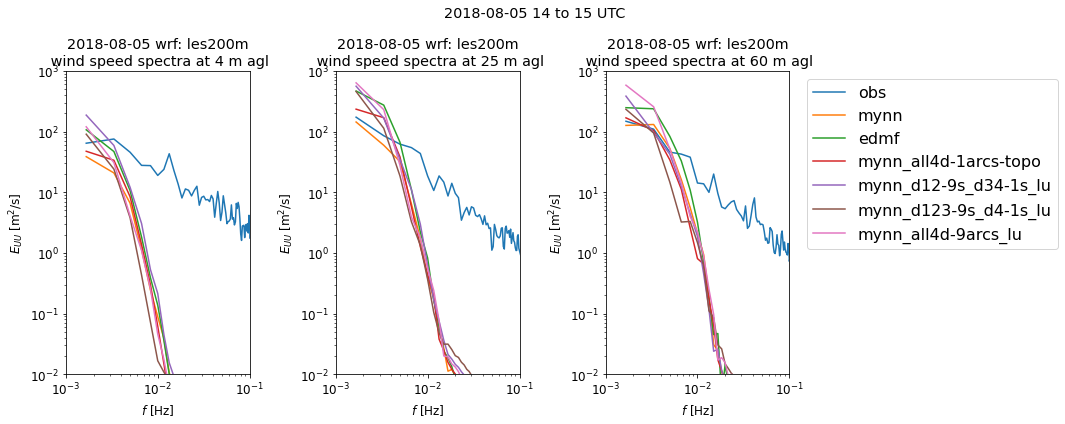

In [30]:
t = t_list[0]

obs4_spectra = get_obs_spectra(obs4_ds, t, t+spectra_avg_time, spectra_window)
obs25_spectra = get_obs_spectra(obs25_ds, t, t+spectra_avg_time, spectra_window)
obs60_spectra = get_obs_spectra(obs60_ds, t, t+spectra_avg_time, spectra_window)

run_spectra_dict = {}
for run in runs_list:
    run_spectra_dict[run] = get_wrf_spectra(runs_dict[run], t, t+spectra_avg_time, 
                                            spectra_window)

plot_4mspectra_dict = {'obs': obs4_spectra.to_dataframe()}
for run in runs_list:
    plot_4mspectra_dict[run] = run_spectra_dict[run].sel(height=4).to_dataframe()

plot_25mspectra_dict = {'obs': obs25_spectra.to_dataframe()}
for run in runs_list:
    plot_25mspectra_dict[run] = run_spectra_dict[run].sel(height=25).to_dataframe()

plot_60mspectra_dict = {'obs': obs60_spectra.to_dataframe()}
for run in runs_list:
    plot_60mspectra_dict[run] = run_spectra_dict[run].sel(height=60).to_dataframe()

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

plt.rcParams.update({'font.size': 12})

_, ax = plot_spectrum(
        datasets=plot_4mspectra_dict,
        fields='wspd',
        showlegend=False, fig=fig, ax=axs[0])

ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

_, ax = plot_spectrum(
        datasets=plot_25mspectra_dict,
        fields='wspd',
        showlegend=False, fig=fig, ax=axs[1])

ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 25 m agl')

_, ax = plot_spectrum(
        datasets=plot_60mspectra_dict,
        fields='wspd',
        showlegend=True, fig=fig, ax=axs[2])

ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 60 m agl')

if t.day == (t+spectra_avg_time).day: 
    plt.suptitle(eval_date+' '+str(t.hour)+' to '+str((t+spectra_avg_time).hour)+' UTC')
else: 
    plt.suptitle(t.strftime('%Y-%m-%d %H')+' UTC to '+(t+spectra_avg_time).strftime('%Y-%m-%d %H')+' UTC')

if sim != 'meso': 
    
    x_start, x_end = 1e-3, 1e-1
    y_start, y_end = 1e-2, 1e3
    
    axs[0].set_xlim(x_start, x_end)
    axs[0].set_ylim(y_start, y_end)
    
    axs[1].set_xlim(x_start, x_end)
    axs[1].set_ylim(y_start, y_end)
    
    axs[2].set_xlim(x_start, x_end)
    axs[2].set_ylim(y_start, y_end)
    
plt.tight_layout()

#         plt.savefig('plots_03d/'+sim+'_'+eval_date+'-'+str(t.hour)+'z_'
#                     +spectra_window+'-'+spectra_avg_freq+'_3spectra.pdf')

plt.show()